In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("final_named_data.csv", index_col='id')
df.head()

,Unnamed: 0,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,76,77,78,81,84,85,86,87,88,name
id,,,,,,,,,,,,,,,,,,,,,
1,0,15943882.0,63,1,NaN,NaN,NaN,NaN,1.0,145.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
2,1,15964847.0,67,1,NaN,NaN,NaN,NaN,4.0,160.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
3,2,15952199.0,67,1,NaN,NaN,NaN,NaN,4.0,120.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
4,3,15929464.0,37,1,NaN,NaN,NaN,NaN,3.0,130.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
6,4,11961207.0,41,0,NaN,NaN,NaN,NaN,2.0,130.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name


In [4]:
df = df.drop(['Unnamed: 0', 'name'], axis=1)

In [37]:
# if not smoke -> cigs=0
# if cigs=0 -> smoke=0
# if cigs != 0 -> smoke = 1
df.loc[df['smoke']==0, 'cigs'] = 0
df.loc[df['cigs']==0, 'smoke'] = 0
df.loc[(df['cigs']!=0) & (df['cigs'].notna()), 'smoke'] = 1

### Remove rows and columns with too many missing values

In [6]:
def clean_data(df, max_missing_ratio_row, max_missing_ratio_column):
    
    missing_ratio_per_row = df.isna().mean(axis=1)
    df_cleaned_rows = df[missing_ratio_per_row < max_missing_ratio_row]

    missing_ratio_per_column = df_cleaned_rows.isna().mean(axis=0)
    df_cleaned = df_cleaned_rows.loc[:, missing_ratio_per_column < max_missing_ratio_column]

    return df_cleaned

max_missing_ratio_row = 0.5
max_missing_ratio_column = 0.5
df_cleaned = clean_data(df, max_missing_ratio_row, max_missing_ratio_column)
df_cleaned.shape

(1343, 60)

In [5]:
df_cleaned.head()

NameError: name 'df_cleaned' is not defined

In [7]:
df_cleaned.to_csv("final_named_and_cleaned_data_0_5.csv")

In [39]:
df_cleaned.isna().sum()

ccf           6
age           0
sex           0
painloc     311
painexer    587
relrest     595
pncaden     604
cp            1
trestbps     53
htn          43
chol        162
smoke       647
cigs        657
fbs          88
dm            0
restecg       2
ekgmo       137
ekgday      142
ekgyr       137
dig         166
prop        162
nitr        164
pro         161
diuretic    181
27          197
thaldur      50
thaltime    643
met         139
thalach     140
thalrest    142
tpeakbps    151
trestbpd    156
tpeakbpd    147
36          148
exang       146
xhypo       148
oldpeak     147
slope       392
cmo         312
cday        311
cyr         313
num           0
lmt         332
ladprox     279
laddist     292
diag        634
cxmain      283
ramus       649
om1         324
om2         654
rcaprox     298
rcadist     313
lvx1         71
lvx2         72
lvx3         73
lvx4         72
lvf          33
75           54
85           51
86           51
87           51
88           51
dtype: i

### Division of data into training and testing

In [40]:
X = df_cleaned.drop(columns=['num'])
y = df_cleaned['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modeling

### Random Forest 

In [27]:
rf = RandomForestClassifier(random_state=42)

grid_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, grid_params, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Najlepsze hiperparametry dla RandomForestClassifier: {best_params}")

Najlepsze hiperparametry dla RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [30]:
best_rf = grid_search.best_estimator_
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

In [27]:
def load_model_and_show_metrics(filename, title):
    with open(filename, 'rb') as f:
        best_rf = pickle.load(f)

    y_pred = best_rf.predict(X_test)

    print("Classification report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.show()

    return y_pred 

Classification report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       103
           1       0.85      0.69      0.76        68
           2       0.73      0.63      0.67        51
           3       0.69      0.81      0.74        36
           4       1.00      0.83      0.91        12

    accuracy                           0.82       270
   macro avg       0.83      0.79      0.80       270
weighted avg       0.82      0.82      0.81       270



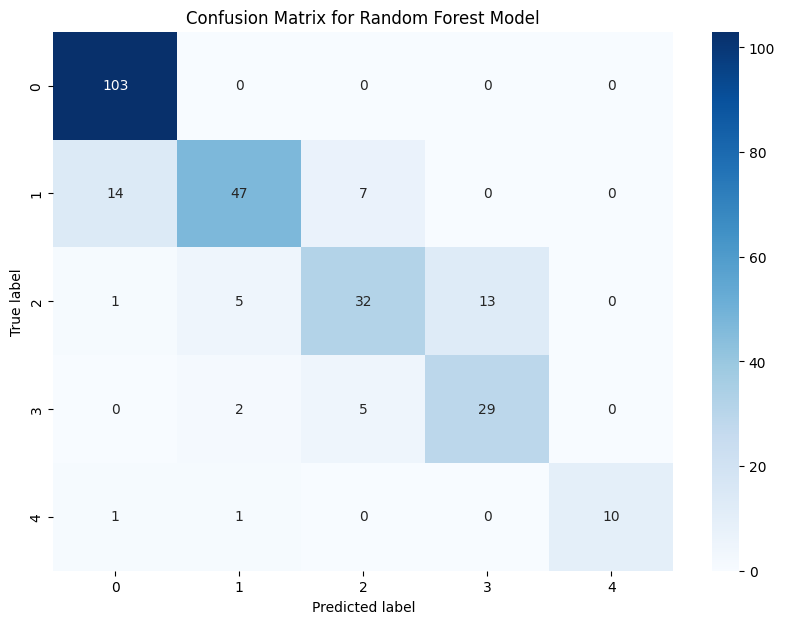

In [41]:
y_pred = load_model_and_show_metrics('random_forest_model.pkl', "Confusion Matrix for Random Forest Model")

**Feature importances**

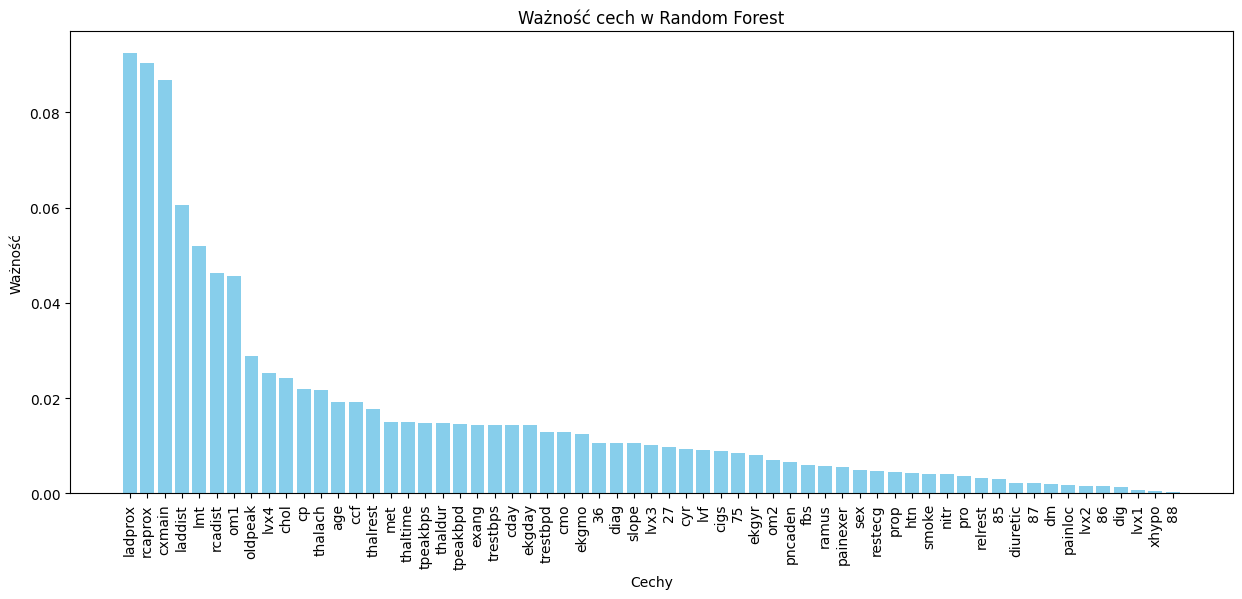

In [22]:
importances = best_rf.feature_importances_
feature_names = X_train.columns 

sorted_idx = np.argsort(importances)[::-1] 
sorted_importances = importances[sorted_idx]
sorted_features = feature_names[sorted_idx]

plt.figure(figsize=(15, 6))
plt.bar(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Cechy")
plt.ylabel("Ważność")
plt.title("Ważność cech w Random Forest")
plt.xticks(rotation=90)
plt.show()

## Final cleaning

In [5]:
df = pd.read_csv("final_named_and_cleaned_data_0_5_with_fram.csv")
df.head()

,Unnamed: 0,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,htn,...,lvx2,lvx3,lvx4,lvf,75,85,86,87,88,framingham_score
0,0,63,1,1.0,1.0,1.0,3.0,1.0,145.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,18
1,1,67,1,1.0,1.0,1.0,3.0,4.0,160.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,20
2,2,67,1,1.0,1.0,1.0,3.0,4.0,120.0,1.0,...,1.0,1.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,17
3,3,37,1,1.0,1.0,1.0,3.0,3.0,130.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,7
4,4,41,0,1.0,0.0,1.0,1.0,2.0,130.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,9


In [14]:
df.isna().sum()

age                 0
sex                 0
painloc             0
painexer            0
relrest             0
pncaden             0
cp                  0
trestbps            0
htn                 0
chol                0
smoke               0
cigs                0
fbs                 0
dm                  0
restecg             0
dig                 0
prop                0
nitr                0
pro                 0
diuretic            0
thaldur             0
thaltime            0
met                 0
thalach             0
thalrest            0
tpeakbps            0
trestbpd            0
tpeakbpd            0
36                  0
exang               0
xhypo               0
oldpeak             0
slope               0
num                 0
lmt                 0
ladprox             0
laddist             0
diag                0
cxmain              0
ramus               0
om1                 0
om2                 0
rcaprox             0
rcadist             0
framingham_score    0
dtype: int

In [13]:
df.loc[df['smoke']==0, 'cigs'] = 0
df[df.cigs.isna()][['cigs', 'smoke']].head(20)


,cigs,smoke


In [8]:
df.drop(
    columns=['Unnamed: 0', 'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', '75', '85',
       '86', '87', '88', '27'], inplace=True
)

In [15]:
df.to_csv("final_named_and_final_cleaned_data_0_5_with_fram.csv")


## Dealing with imbalance - SMOTE

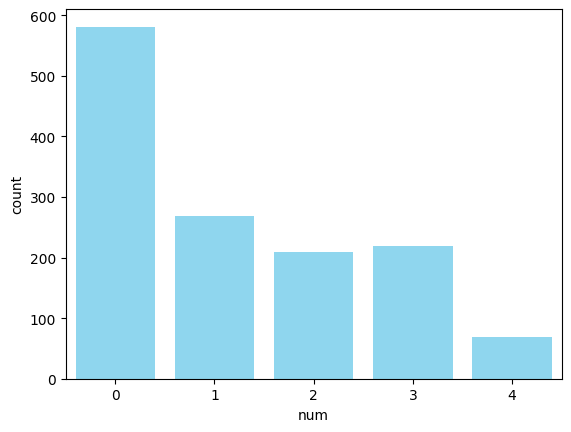

In [16]:
sns.countplot(x=df['num'], color='deepskyblue', alpha=0.5)
plt.show()

In [ ]:
X = df.drop(columns=['num'])
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
print(X.shape)
for i in df['num'].unique():
    print(f"Class {i}: {y.value_counts()[i]} samples")

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(X_smote.shape)
for i in df['num'].unique():
    print(f"Class {i}: {y_smote.value_counts()[i]} samples")

(1347, 44)
Class 0: 581 samples
Class 2: 209 samples
Class 1: 269 samples
Class 3: 219 samples
Class 4: 69 samples
(2390, 44)
Class 0: 478 samples
Class 2: 478 samples
Class 1: 478 samples
Class 3: 478 samples
Class 4: 478 samples


# Modeling

### After dealing with NaNs

In [23]:
rf = RandomForestClassifier(random_state=42)

grid_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, grid_params, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Najlepsze hiperparametry dla RandomForestClassifier: {best_params}")

best_rf = grid_search.best_estimator_
with open('random_forest_model_not_nans.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

Najlepsze hiperparametry dla RandomForestClassifier: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Classification report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       103
           1       0.74      0.62      0.67        68
           2       0.73      0.53      0.61        51
           3       0.67      0.83      0.74        36
           4       0.83      0.83      0.83        12

    accuracy                           0.78       270
   macro avg       0.76      0.76      0.75       270
weighted avg       0.77      0.78      0.77       270



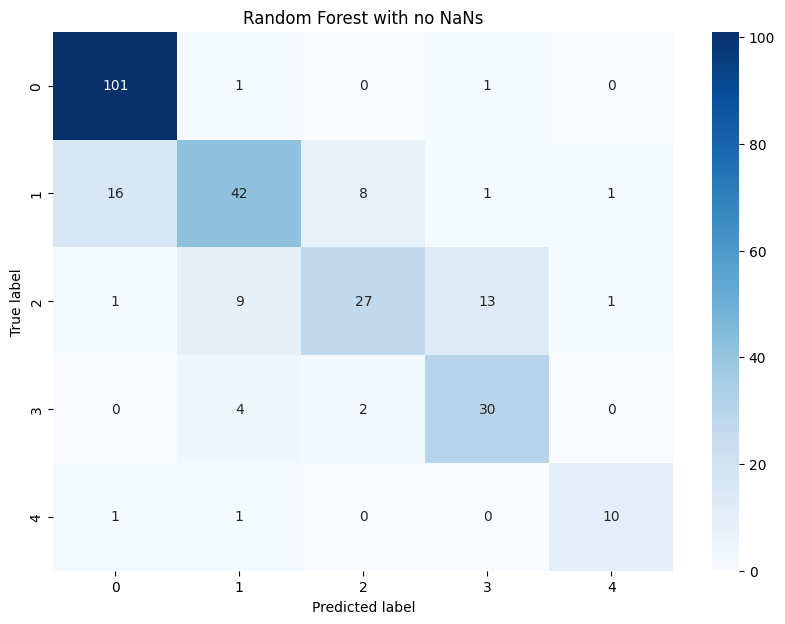

In [29]:
y_pred_2 = load_model_and_show_metrics('random_forest_model_not_nans.pkl', "Random Forest with no NaNs")

### After SMOTE

In [33]:
rf = RandomForestClassifier(random_state=42)

grid_params = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, grid_params, cv=5)
grid_search.fit(X_smote, y_smote)

best_params = grid_search.best_params_
print(f"Najlepsze hiperparametry dla RandomForestClassifier po SMOTE: {best_params}")

best_rf = grid_search.best_estimator_
with open('random_forest_model_not_nans_smote.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

Najlepsze hiperparametry dla RandomForestClassifier po SMOTE: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Classification report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       103
           1       0.79      0.60      0.68        68
           2       0.72      0.61      0.66        51
           3       0.70      0.83      0.76        36
           4       0.85      0.92      0.88        12

    accuracy                           0.79       270
   macro avg       0.78      0.79      0.78       270
weighted avg       0.79      0.79      0.78       270



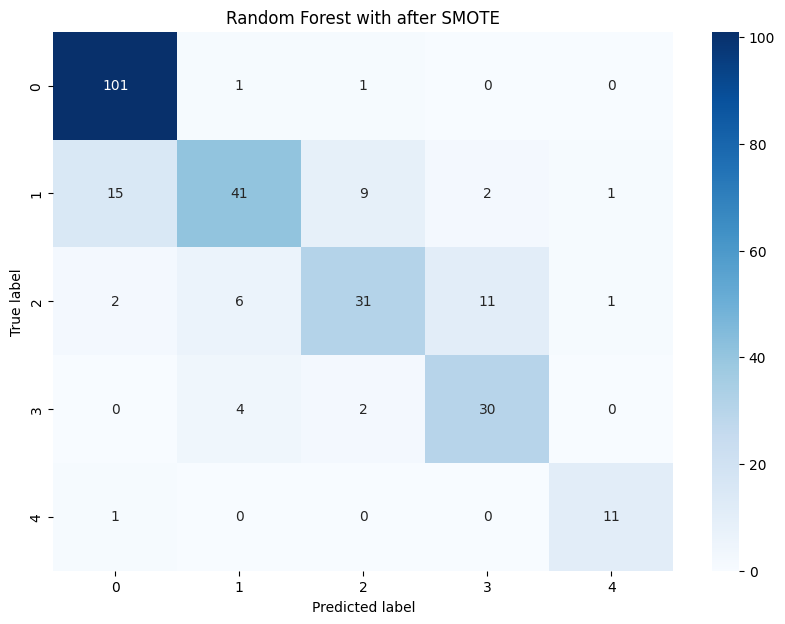

In [34]:
y_pred_3 = load_model_and_show_metrics('random_forest_model_not_nans_smote.pkl', "Random Forest with after SMOTE")